In [2]:
'''
1. Fresh run on all genomes with the lastest GeneMark-ES
2. Parse GeneMark-ES output model file in the last run and plot exon/spacer/intron length distribution 
3. find connect between exon density and the exon/spacer/intron distribution
Build class ESModel, to extract information(spacer, exon, intron length distribution)
'''
import pandas as pd
import re
import numpy as np
import matplotlib.pylab as plt
% matplotlib inline
fulldata = pd.read_csv("../1_DataSmall/fullTableInfoGff3GffRNA.csv")
fulldata.index = fulldata['shortName']
# print fulldata.columns

# The files under the fastapath were obtained from the script created in 2_Consolidation
# buildingMarkovModel part
fastaPath ="/home/richard/largeDataSet/genomeFasta/" 
targetConvergePath = "/home/richard/largeDataSet/ES_Run_Result_Aug27/"
targetPath = "/scratch/fungi/ES_Run_Aug2015/"

In [3]:
## make scripts to run GeneMark-ES that distribute the work to m machines


##########################################################################
# first of all, copy fasta files to nodes local drive: scratch
# command to check is nodes are good: for((i=10;i<34;i++)); do ssh node0"$i" echo "$i";done
# nodes 007, 031 fails
nodeNum = ["00"+str(i) for i in range(1,34) if i!=7 and i!=31]; nodeNum = map(lambda x: "node"+x[-3:], nodeNum)
print "Number of nodes active:",len(nodeNum)
numNode = len(nodeNum)

# split shortName column as a list of 31 sublist
shortName = list(fulldata['shortName'])
shortNameSublists = [shortName[i::numNode] for i in range(numNode)]

# assign each node a sublist of shortName
nodeJob = zip(nodeNum,shortNameSublists)

# make folder ES_Run_Aug2015 on each node's local drive, /scratch/fungi/ and copy the relavent shortName folder
# mkdir to nodes was performed on command line
script = ""
for node,shorNames in nodeJob:
    for shortName in shorNames:
        script += "ssh {} cp -r {}{} {}\n".format(node,fastaPath,shortName, targetPath)
with open("/home/richard/tempFile/cp_fasta.sh",'w') as f: f.write(script)
##########################################################################

##########################################################################
#execute GeneMark-ES on from each node

es_command = "/home/alexl/DISTR/gmes_petap/gmes_petap.pl --ES --fungus --min_contig 10000 --cores 8 --v  --seq "
script = ""
for node,shorNames in nodeJob:
    for shortName in shorNames:
        try:
            script += 'nohup ssh {} "cd {}{}; {}{}; cd .." &\n '.format(node,targetPath,shortName,es_command,fulldata.loc[shortName]['fastaName'][:-3])
        except:
            print "problem with",shortName
with open("/home/richard/tempFile/run_ES_Aug2015.sh",'w') as f: f.write(script)  

# print script
##########################################################################
## The above script has problem
## the correct way to do it is to add nohup the first time it use a new node

## copy mod file on the 4th run
modfilePath = "run/ES_C_4/ES_C_4.mod"
targetModPath = "/home/richard/largeDataSet/ES_Run_modfileAug2015/"
script = ""
for node,shorNames in nodeJob:
    for shortName in shorNames:
        script += 'ssh {} cp {}{}/{} {}{}.ES_C_4.mod\n'.format(node, targetPath, shortName,modfilePath,targetModPath, shortName)
with open("/home/richard/tempFile/cp_run_ES_mod_Aug2015.sh",'w') as f: f.write(script)  

Number of nodes active: 31
problem with Neute_matA2
problem with Pospl1
problem with Crypa2
problem with Ustma1
problem with Sporo1


In [4]:
## create an extra column of label to point out if ES is successful
## parse from the nohup file to capture ES failure
ES_fail_text = ""
with open("/home/richard/research/1_DataSmall/textToBeParsed/ES_output_20150828.txt") as f: ES_fail_text = f.read()
## capture failure by regular expression
pattern = "ES_Run_Aug2015\/(.*?)\/run/ES_C_4"
shortNamefailedES = set(re.findall(pattern, ES_fail_text))
print "There were {} genomes failed GeneMark-ES run.".format(len(shortNamefailedES))

# add the column to fulldata set
ES = ['pass' for i in range(fulldata.shape[0])]
fulldata['ES'] = ES; 
for shortName in shortNamefailedES: fulldata.loc[shortName,'ES'] = 'fail'
noGenomeSpecies = ['Neute_matA2','Pospl1','Crypa2','Ustma1','Sporo1']
for shortName in noGenomeSpecies: fulldata.loc[shortName,'ES'] = 'NA'
fulldata.to_csv("/home/richard/research/1_DataSmall/fullTableInfoGff3GffRNAES_20150828.csv", index = None)

There were 71 genomes failed GeneMark-ES run.


In [5]:
############################################
spacerData = []
switch = False
with open("/home/richard/largeDataSet/ES_Run_modfileAug2015/Aaoar1.ES_C_4.mod") as f:
    for line in f:
        if switch:
            spacerData.append(line)
        if "$BP_ACC_DISTR" in line:
            switch = True
        if "40\t" in line:
            switch = False
            break
            
spacerData = map(lambda line: line.rstrip().split("\t"), spacerData)
spacerDistr = map(lambda (a,b): float(b), spacerData)
positionProb = np.array(spacerDistr)
# print positionProb
range(2,41)[positionProb.argmax()]
##############################################

8

In [6]:
## Build class ESModel, to extract information(spacer, exon, intron length distribution)
class ESModel():
    """Take in 4th run of model file as text and extract info"""
    def __init__(self, filename):
        self.f = open(filename)
    
    def maxSpacerPosition(self):
        '''
        return the position with the highest probability
        '''
        spacerData = []
        switch = False
        for line in self.f:
            if switch:
                spacerData.append(line)
            if "$BP_ACC_DISTR" in line:
                switch = True
            if "40\t" in line:
                switch = False
                break

        spacerData = map(lambda line: line.rstrip().split("\t"), spacerData)
        spacerDistr = map(lambda (a,b): float(b), spacerData)
        positionProb = np.array(spacerDistr)
        # print positionProb
        return range(2,41)[positionProb.argmax()]
    
    def maxExonPosition(self, length = 9999):
        '''
        return the position with the highest probability
        '''
        exonData = []
        switch = False
        for line in self.f:
            if switch:
                exonData.append(line)
            if "$EXON_DISTR" in line:
                switch = True
            if switch and "{}\t".format(length) in line:
                switch = False
                break

        exonData = map(lambda line: line.rstrip().split("\t"), exonData)
        exonDistr = map(lambda (a,b): float(b), exonData)
        positionProb = np.array(exonDistr)
        # print positionProb
        try:
            return range(3,10000)[positionProb.argmax()]
        except:
            return 'NA'

    def maxIntronPosition(self, length = 3000):
            '''
            return the position with the highest probability
            '''
            intronData = []
            switch = False
            for line in self.f:
                if switch:
                    intronData.append(line)
                if "$INTRON_DISTR" in line:
                    switch = True
                if switch and "{}\t".format(length) in line:
                    switch = False
                    break

            intronData = map(lambda line: line.rstrip().split("\t"), intronData)
            intronDistr = map(lambda (a,b): float(b), intronData)
            positionProb = np.array(intronDistr)
            # print positionProb
            try:
                return range(20,3000)[positionProb.argmax()]
            except:
                return 'NA'

    def maxDonorToBpIntronPosition(self, length = 3000):
            '''
            return the position with the highest probability
            '''
            intronData = []
            switch = False
            for line in self.f:
                if switch:
                    intronData.append(line)
                if "$DON_BP_DISTR" in line:
                    switch = True
                if switch and "{}\t".format(length) in line:
                    switch = False
                    break

            intronData = map(lambda line: line.rstrip().split("\t"), intronData)
            intronDistr = map(lambda (a,b): float(b), intronData)
            positionProb = np.array(intronDistr)
            # print positionProb
            try:
                return range(20,3000)[positionProb.argmax()]
            except:
                return 'NA'
    def close(self):
        self.f.close()

In [7]:
## add columns for exon density according to gff3, if gff3 is not available, use gff
fulldata = pd.read_csv("../1_DataSmall/fullTableInfoGff3GffRNAES_20150828.csv")
exonDensityGff3 = fulldata['numExonGff3']/fulldata['numGeneGff3']
exonDensityGff = fulldata['numExonGff']/fulldata['numGeneGff']
fulldata['exonDensityGff3'] = exonDensityGff3
fulldata['exonDensityGff'] = exonDensityGff

fulldata.index = fulldata['shortName']
cols = ['shortName', 'longName', 'fastaName', 'gffName', 'gff3Name', 'gc', 'numGeneGff3', 'numExonGff3', 'exonDensityGff3', 'numIntronGff3', 'intronDensityGff3', 'numGeneGff', 'numExonGff', 'exonDensityGff', 'numIntronGff', 'intronDensityGff', 'rnaSeqCount', 'ES']
fulldata = fulldata[cols]
fulldata.to_csv("/home/richard/research/1_DataSmall/fullTableInfoGff3GffRNAESwithDensity20150829.csv", index = None)

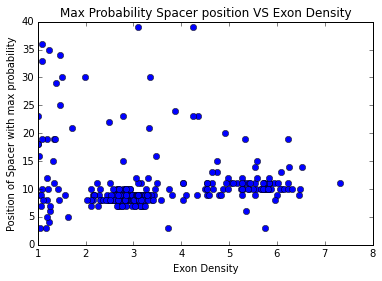

In [8]:
## generate plot of spacer length distribution and figure out the relation between exon density
## find the exon density VS max position
exonDensityExonDistrPair = []
modelFilePath = "/home/richard/largeDataSet/ES_Run_modfileAug2015/"
for shortName in fulldata.index:
    if fulldata.loc[shortName,'ES'] == 'pass':
        filepath = "{}{}{}".format(modelFilePath, shortName,".ES_C_4.mod")
        model = ESModel(filepath)
        ## make a list of 3-tuple, shortName, gc, maxSpacerPosition
        exonDensity1 = fulldata.loc[shortName,'exonDensityGff3']
        exonDensity2 = fulldata.loc[shortName,'exonDensityGff']
        exonDensity = exonDensity1 if pd.isnull(exonDensity1) else exonDensity2
        exonDensityExonDistrPair.append((shortName,exonDensity,model.maxSpacerPosition())) # need to pair this with gc
        model.close()
#         print filepath
data = np.array(exonDensityExonDistrPair)
plt.plot(data[:,1], data[:,2], "o")
plt.xlabel("Exon Density")
plt.ylabel("Position of Spacer with max probability")
plt.title("Max Probability Spacer position VS Exon Density")

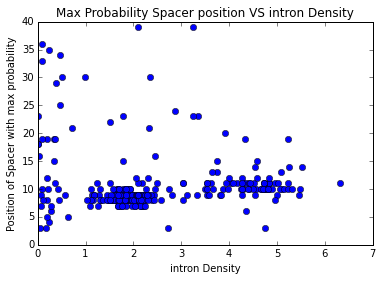

In [501]:
## generate plot of spacer length distribution and figure out the relation between intron density
## find the intron density VS max position
intronDensityExonDistrPair = []
modelFilePath = "/home/richard/largeDataSet/ES_Run_modfileAug2015/"
for shortName in fulldata.index:
    if fulldata.loc[shortName,'ES'] == 'pass':
        filepath = "{}{}{}".format(modelFilePath, shortName,".ES_C_4.mod")
        model = ESModel(filepath)
        ## make a list of 3-tuple, shortName, gc, maxSpacerPosition
        intronDensity1 = fulldata.loc[shortName,'intronDensityGff3']
        intronDensity2 = fulldata.loc[shortName,'intronDensityGff']
        intronDensity = intronDensity1 if pd.isnull(intronDensity1) else intronDensity2
        intronDensityExonDistrPair.append((shortName,intronDensity,model.maxSpacerPosition())) # need to pair this with gc
        model.close()
#         print filepath
data = np.array(intronDensityExonDistrPair)
plt.plot(data[:,1], data[:,2], "o")
plt.xlabel("intron Density")
plt.ylabel("Position of Spacer with max probability")
plt.title("Max Probability Spacer position VS intron Density")

In [502]:
## count number of species that have intronDesity > 1 and have max(prob) position > 14
intronDensityVSmaxSpacerPosition = pd.DataFrame(data)
f1 = np.array(intronDensityVSmaxSpacerPosition.icol(1), dtype = "float64") > 1
f2 = np.array(intronDensityVSmaxSpacerPosition.icol(2), dtype = 'int32') > 14
sum(f1&f2) # these are mostly the outliers

16

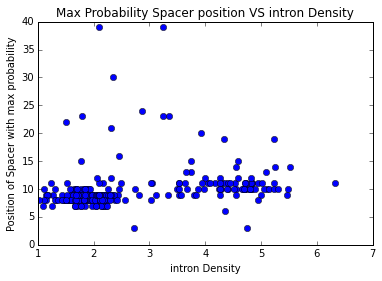

In [10]:
## get rid of the part with intron density < 1

## generate plot of spacer length distribution and figure out the relation between intron density
## find the intron density VS max position
intronDensityExonDistrPair = []
modelFilePath = "/home/richard/largeDataSet/ES_Run_modfileAug2015/"

f1 = fulldata['intronDensityGff3'] > 1
f2 = fulldata['intronDensityGff'] > 1
filteredData = fulldata[f1|f2]


for shortName in filteredData.index:
    if filteredData.loc[shortName,'ES'] == 'pass':
        filepath = "{}{}{}".format(modelFilePath, shortName,".ES_C_4.mod")
        model = ESModel(filepath)
        ## make a list of 3-tuple, shortName, gc, maxSpacerPosition
        intronDensity1 = filteredData.loc[shortName,'intronDensityGff3']
        intronDensity2 = filteredData.loc[shortName,'intronDensityGff']
        intronDensity = intronDensity1 if pd.isnull(intronDensity1) else intronDensity2
        intronDensityExonDistrPair.append((shortName,intronDensity,model.maxSpacerPosition())) # need to pair this with gc
        model.close()
#         print filepath
data = np.array(intronDensityExonDistrPair)
plt.plot(data[:,1], data[:,2], "o")
plt.xlabel("intron Density")
plt.ylabel("Position of Spacer with max probability")
plt.title("Max Probability Spacer position VS intron Density")

In [12]:
## generate plot of exon length distribution and figure out the relation between intron density
## find the intron density VS max position
intronDensityExonDistrPair = []
modelFilePath = "/home/richard/largeDataSet/ES_Run_modfileAug2015/"
f1 = fulldata['intronDensityGff3'] > 1
f2 = fulldata['intronDensityGff'] > 1
filteredData = fulldata[f1|f2]
for shortName in filteredData.index:
    if filteredData.loc[shortName,'ES'] == 'pass':
        filepath = "{}{}{}".format(modelFilePath, shortName,".ES_C_4.mod")
        model = ESModel(filepath)
        ## make a list of 3-tuple, shortName, gc, maxSpacerPosition
        intronDensity1 = filteredData.loc[shortName,'intronDensityGff3']
        intronDensity2 = filteredData.loc[shortName,'intronDensityGff']
        intronDensity = intronDensity1 if pd.isnull(intronDensity1) else intronDensity2
        intronDensityExonDistrPair.append((shortName,filteredData.loc[shortName,'gc'],intronDensity,model.maxExonPosition())) # need to pair this with gc
        model.close()
#         print filepath
data = np.array(intronDensityExonDistrPair)

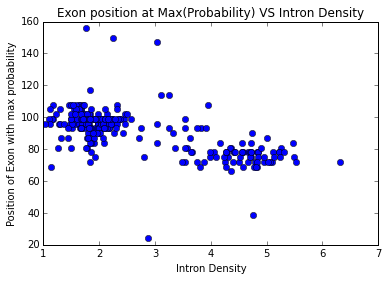

In [13]:
# plotting continue from last part, X = intron density
plt.plot(data[:,2], data[:,3], "o")
plt.xlabel("Intron Density")
plt.ylabel("Position of Exon with max probability")
plt.title("Exon position at Max(Probability) VS Intron Density")

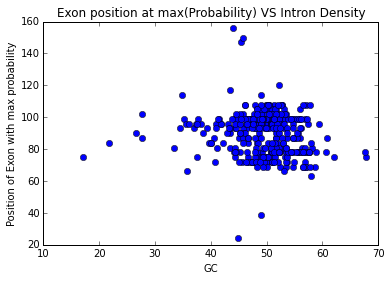

In [14]:
# plotting continue from last part, X = GC
plt.plot(data[:,1], data[:,3], "o")
plt.xlabel("GC")
plt.ylabel("Position of Exon with max probability")
plt.title("Exon position at max(Probability) VS Intron Density")

In [15]:
## generate plot of intron length distribution and figure out the relation between intron density
## find the intron density VS max position
intronDensityIntronDistrPair = []
modelFilePath = "/home/richard/largeDataSet/ES_Run_modfileAug2015/"
f1 = fulldata['intronDensityGff3'] > 1
f2 = fulldata['intronDensityGff'] > 1
filteredData = fulldata[f1|f2]
for shortName in filteredData.index:
    if filteredData.loc[shortName,'ES'] == 'pass':
        filepath = "{}{}{}".format(modelFilePath, shortName,".ES_C_4.mod")
        model = ESModel(filepath)
        ## make a list of 3-tuple, shortName, gc, maxSpacerPosition
        intronDensity1 = filteredData.loc[shortName,'intronDensityGff3']
        intronDensity2 = filteredData.loc[shortName,'intronDensityGff']
        intronDensity = intronDensity1 if pd.isnull(intronDensity1) else intronDensity2
        intronDensityIntronDistrPair.append((shortName,filteredData.loc[shortName,'gc'],intronDensity,model.maxIntronPosition())) # need to pair this with gc
        model.close()
#         print filepath
data = np.array(intronDensityIntronDistrPair)

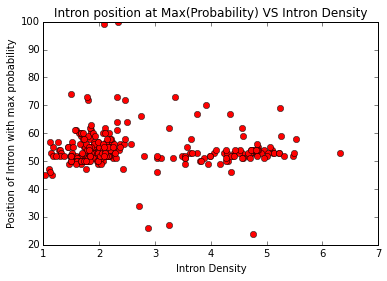

In [16]:
# plotting continue from last part, X = intron density
plt.plot(data[:,2], data[:,3], "or")
plt.xlabel("Intron Density")
plt.ylabel("Position of Intron with max probability")
plt.title("Intron position at Max(Probability) VS Intron Density")

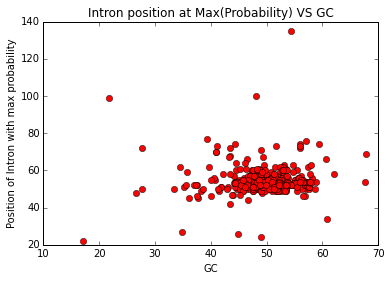

In [17]:
# plotting continue from last part, X = GC
plt.plot(data[:,1], data[:,3], "or")
plt.xlabel("GC")
plt.ylabel("Position of Intron with max probability")
plt.title("Intron position at Max(Probability) VS GC")

In [18]:
## generate plot of donor to BP intron length distribution and figure out the relation between intron density
## find the intron density VS max position
intronDensityIntronDistrPair = []
modelFilePath = "/home/richard/largeDataSet/ES_Run_modfileAug2015/"
f1 = fulldata['intronDensityGff3'] > 1
f2 = fulldata['intronDensityGff'] > 1
filteredData = fulldata[f1|f2]
for shortName in filteredData.index:
    if filteredData.loc[shortName,'ES'] == 'pass':
        filepath = "{}{}{}".format(modelFilePath, shortName,".ES_C_4.mod")
        model = ESModel(filepath)
        ## make a list of 3-tuple, shortName, gc, maxSpacerPosition
        intronDensity1 = filteredData.loc[shortName,'intronDensityGff3']
        intronDensity2 = filteredData.loc[shortName,'intronDensityGff']
        intronDensity = intronDensity1 if pd.isnull(intronDensity1) else intronDensity2
        intronDensityIntronDistrPair.append((shortName,filteredData.loc[shortName,'gc'],intronDensity,model.maxDonorToBpIntronPosition())) # need to pair this with gc
        model.close()
#         print filepath
data = np.array(intronDensityIntronDistrPair)

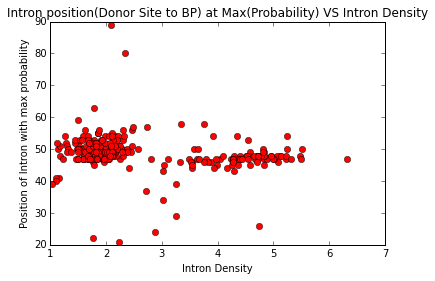

In [19]:
# plotting continue from last part, X = intron density
plt.plot(data[:,2], data[:,3], "or")
plt.xlabel("Intron Density")
plt.ylabel("Position of Intron with max probability")
plt.title("Intron position(Donor Site to BP) at Max(Probability) VS Intron Density")

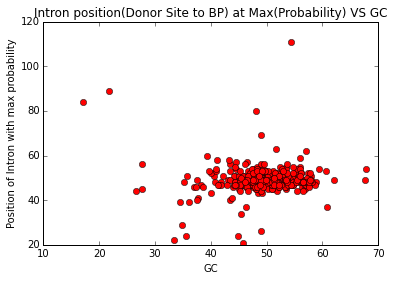

In [20]:
# plotting continue from last part, X = GC
plt.plot(data[:,1], data[:,3], "or")
plt.xlabel("GC")
plt.ylabel("Position of Intron with max probability")
plt.title("Intron position(Donor Site to BP) at Max(Probability) VS GC")